# Simulation to evaluate the reason of inflation

1. 
1. Take the chromosome-wide simulation in 1st experiment.
2. Perform a GWAS on the data on chromosome 22.
3. Perform clumping on the data on chromosome 22.
4. For every GWAS hit, find the true SNPs, and evaluate the properties. Heterogeneity ~ distance to causal, strategies to find causal variables.
5. Run heterogeneity test on the index SNPs.

# Perform GWAS clumping

In [7]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [8]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)
SIM_PHENO_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/01_genome_wide_simulate/out/pheno"
# convert to PLINK1
def convert_plink1():
    for chrom in range(1, 23):
        pfile = join(GENO_DIR, f"imputed/chr{chrom}")
        admix.tools.plink2.run(
            f"--pfile {pfile} --make-bed --out out/genome-wide/PLINK/chr{chrom}"
        )


# convert_plink1()

In [9]:
def submit_gwas_clump(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    for chrom in range(1, 23):
        out_prefix = f"out/genome-wide/clump/{prefix}.sim_{sim_i}.chr{chrom}"
        admix.tools.plink2.gwas(
            pfile=join(GENO_DIR, f"imputed/chr{chrom}"),
            df_sample_info=df_sample_info,
            pheno_col=f"SIM_{sim_i}",
            out_prefix=out_prefix,
            clean_tmp_file=True,
        )
        admix.tools.plink.clump(
            bfile=f"out/genome-wide/PLINK/chr{chrom}",
            assoc_path=out_prefix + ".assoc",
            out_prefix=out_prefix,
            p1=5e-8,
            p2=1e-4,
            r2=0.1,
            kb=3000,
        )
        os.remove(out_prefix + ".assoc")
    # merging all the clumping
    df_clump = []
    clump_file_prefix = f"out/genome-wide/clump/{prefix}.sim_{sim_i}"
    for chrom in range(1, 23):
        clumped_file = clump_file_prefix + f".chr{chrom}.clumped"
        with open(clumped_file) as f:
            lines = f.readlines()
            if len(lines) == 1:
                continue
        df_clump.append(pd.read_csv(clumped_file, delim_whitespace=True))
    df_clump = pd.concat(df_clump)
    df_clump.to_csv(clump_file_prefix + f".clumped", index=False, sep="\t")
    # clean up
    for f in glob.glob(clump_file_prefix + ".chr*"):
        os.remove(f)

In [10]:
# define the simulation parameters
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [0.5], [0.0001, 0.001, 0.01, 1.0], [1.0], ["mafukb"], np.arange(100)
        )
    ],
    columns=["hsq", "pcausal", "cor", "hermodel", "sim_i"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"hsq-{row.hsq}-pcausal-{row.pcausal}-cor-{row.cor}-hermodel-{row.hermodel}",
    axis=1,
)

In [11]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=80,
    memory_g=20,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_gwas_clump, df_params.prefix, df_params.sim_i)

# Heterogeneity test

In [114]:
def submit_test_het(prefix, sim_i):
    df_clump = (
        pd.read_csv(f"out/genome-wide/clump/{prefix}.sim_{sim_i}.clumped", sep="\t")
        .set_index("SNP")
        .sort_values(["CHR", "BP"])
    )
    df_pheno = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )[f"SIM_{sim_i}"]

    df_sum = []
    for chrom, df_chrom in df_clump.groupby("CHR"):

        dset_chrom = admix.dataset.read_dataset(
            pfile=join(GENO_DIR, f"imputed/chr{chrom}"), n_anc=2
        )[df_chrom.index.values]

        df_tmp = admix_genet_cor.marginal_het(
            dset_chrom.geno, dset_chrom.lanc, df_pheno
        )
        df_tmp["assoc_p"] = admix.assoc.marginal_fast(
            geno=dset_chrom.geno, lanc=dset_chrom.lanc, pheno=df_pheno, cov=None
        )
        df_tmp["plink_assoc_p"] = df_chrom["P"].values
        df_tmp["snp"] = df_chrom.index.values
        df_sum.append(df_tmp)
    df_sum = pd.concat(df_sum)
    df_sum = df_sum[
        [
            "snp",
            "het_pval",
            "coef1",
            "se1",
            "coef2",
            "se2",
            "assoc_p",
            "plink_assoc_p",
        ]
    ]
    df_sum.to_csv(
        f"out/genome-wide/clump-summary/{prefix}.sim_{sim_i}.tsv", index=False, sep="\t"
    )

In [117]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=10,
    memory_g=16,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_test_het, df_params.prefix, df_params.sim_i)

In [184]:
df_params["out"] = df_params.apply(
    lambda x: f"out/genome-wide/clump-summary/{x.prefix}.sim_{x.sim_i}.tsv", axis=1
)

In [185]:
df_rls = []
for i, param in df_params.iterrows():
    if os.path.exists(param.out):
        df_tmp = pd.read_csv(param.out, sep="\t")
        df_tmp["pcausal"] = param.pcausal
        df_tmp["hsq"] = param.hsq
        df_tmp["sim_i"] = param.sim_i
        df_rls.append(df_tmp)
df_rls = pd.concat(df_rls).reset_index(drop=True)
# filter for SNPs with super small MAF in either one of the populations
df_rls = df_rls[(df_rls.se1 > 1e-6) & (df_rls.se2 > 1e-6)]
df_rls["plink_assoc_p_bin"] = pd.qcut(df_rls["plink_assoc_p"], q=5)

In [186]:
df_rls_grouped = df_rls.groupby(["pcausal", "plink_assoc_p_bin"])
df_plot = pd.concat(
    [
        df_rls_grouped.apply(lambda x: admix.data.lambda_gc(x["het_pval"])),
        df_rls_grouped.apply(lambda x: pearsonr(x["coef1"], x["coef2"])[0]),
    ],
    axis=1,
)
df_plot.columns = ["lambda_gc", "pearsonr"]
df_plot = df_plot.reset_index(drop=False)

Text(0, 0.5, "Pearson's correlation")

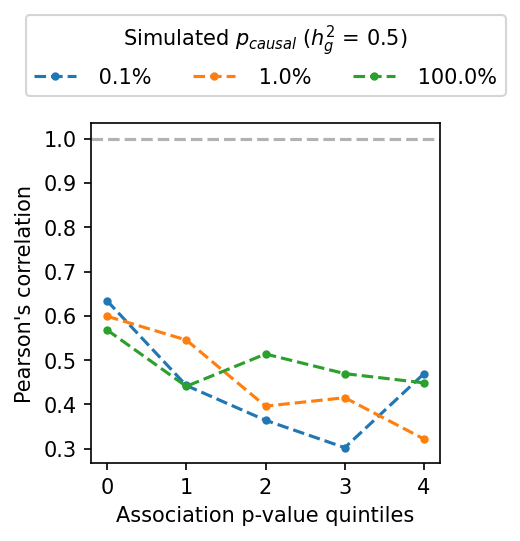

In [193]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for pcausal in df_plot.pcausal.unique():
    df_tmp = df_plot[df_plot.pcausal == pcausal]
    ax.plot(
        df_tmp.plink_assoc_p_bin.cat.codes,
        df_tmp.pearsonr,
        ".--",
        label=f"{pcausal * 100 : .1f}%",
    )

ax.legend(
    loc="center",
    bbox_to_anchor=[0.5, 1.2],
    ncol=3,
    title="Simulated $p_{causal}$ ($h_g^2$ = 0.5)",
)
ax.axhline(y=1, color="black", ls="--", alpha=0.3)
ax.set_xticks(df_tmp.plink_assoc_p_bin.cat.codes)
ax.set_xticklabels(df_tmp.plink_assoc_p_bin.cat.codes)
ax.set_xlabel("Association p-value quintiles")
ax.set_ylabel("Pearson's correlation")